In [1]:
library(tidyverse)
library(readr)
library(caret)
library(xgboost)
library(randomForest)
library(lightgbm)
library(ranger)
library(rBayesianOptimization)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift



Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin


In [2]:
data <- read_csv("insurance.csv")

Rows: 1338 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# preprocessing binary categorical columns
data$sex <- as.numeric(data$sex == "male")  # female=0 and male=1
data$smoker <- as.numeric(data$smoker == "yes")  # yes=1 and no=0

In [4]:
# one-hot encoding categorical columns
dummies <- caret::dummyVars(~ ., data = data[, "region", drop = FALSE])
dummy_data <- predict(dummies, newdata = data[, "region", drop = FALSE])

# Convert to dataframe and rename columns
dummy_data <- as.data.frame(dummy_data)
colnames(dummy_data) <- gsub("region", "", colnames(dummy_data), fixed = TRUE)

# Bind dummy variables back to data
data <- bind_cols(data, dummy_data)

# Drop region column
data <- data %>% select(-region)

In [5]:
# Split data proportionally based on target column.
set.seed(42)
training_samples <- data %>% 
  select(charges) %>% 
  unlist() %>% 
  createDataPartition(p = 0.8, list = FALSE)

train_data <- data[training_samples, ]
test_data  <- data[-training_samples, ]

In [6]:
# linear regression model
model <- train(charges ~ ., data = train_data, method = "lm")
predictions <- predict(model, newdata = test_data)
RMSE(predictions, test_data$charges)
rmse_lr <- RMSE(predictions, test_data$charges)

[1] 6369.243

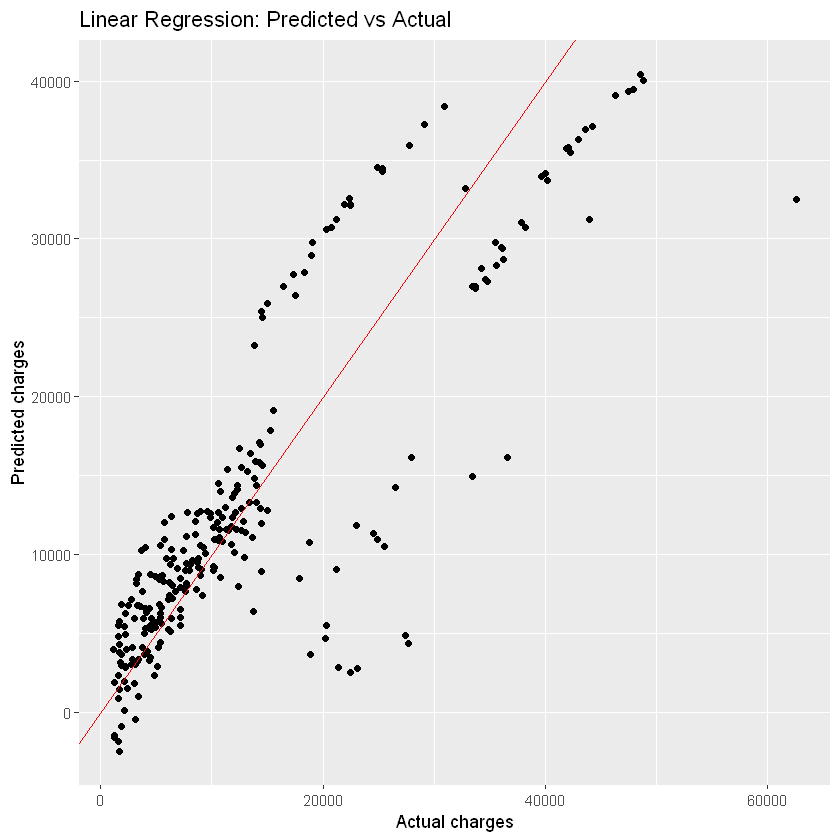

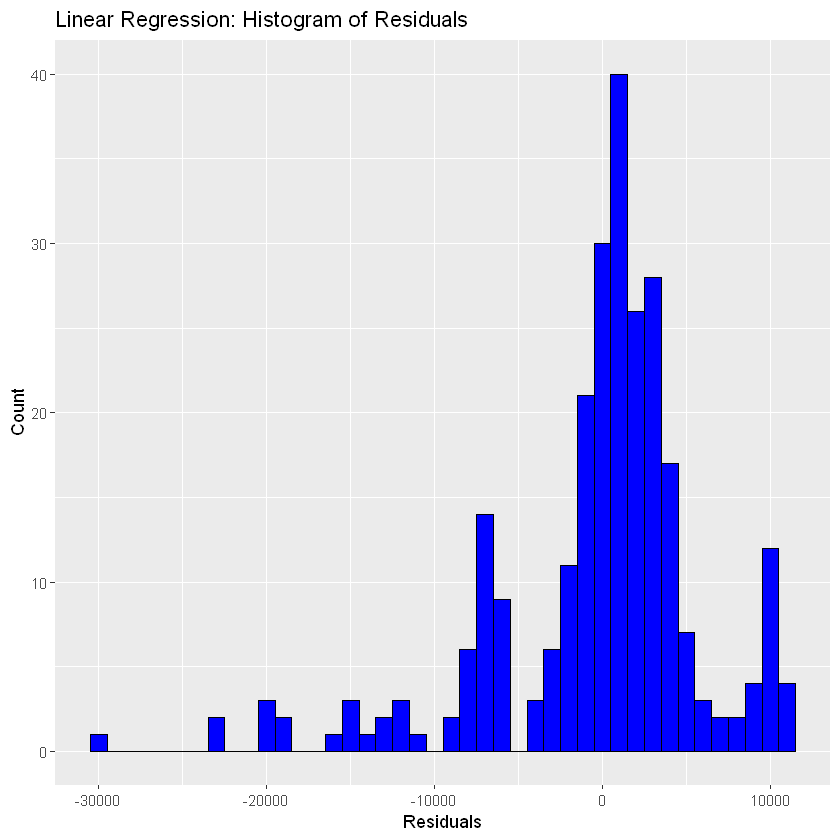

In [7]:
# lin reg model plots
df_lr <- data.frame(Actual = test_data$charges, Predicted = predictions)
ggplot(df_lr, aes(x = Actual, y = Predicted)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  ggtitle("Linear Regression: Predicted vs Actual") +
  xlab("Actual charges") + ylab("Predicted charges")

df_lr$residuals <- df_lr$Predicted - df_lr$Actual
ggplot(df_lr, aes(x = residuals)) +
  geom_histogram(binwidth = 1000, fill = 'blue', color = 'black') +
  ggtitle("Linear Regression: Histogram of Residuals") +
  xlab("Residuals") + ylab("Count")

In [8]:
# RF model
set.seed(42)
rf_grid <- expand.grid(mtry = c(2, 3, 4), splitrule = "variance", min.node.size = c(1, 3, 5))
rf_ctrl <- trainControl(method = "cv", number = 5, search = "grid")

model_rf <- train(charges ~ ., data = train_data, method = "ranger", trControl = rf_ctrl, tuneGrid = rf_grid)
predictions_rf <- predict(model_rf, newdata = test_data)
RMSE(predictions_rf, test_data$charges)
rmse_rf <- RMSE(predictions_rf, test_data$charges)

[1] 5232.831

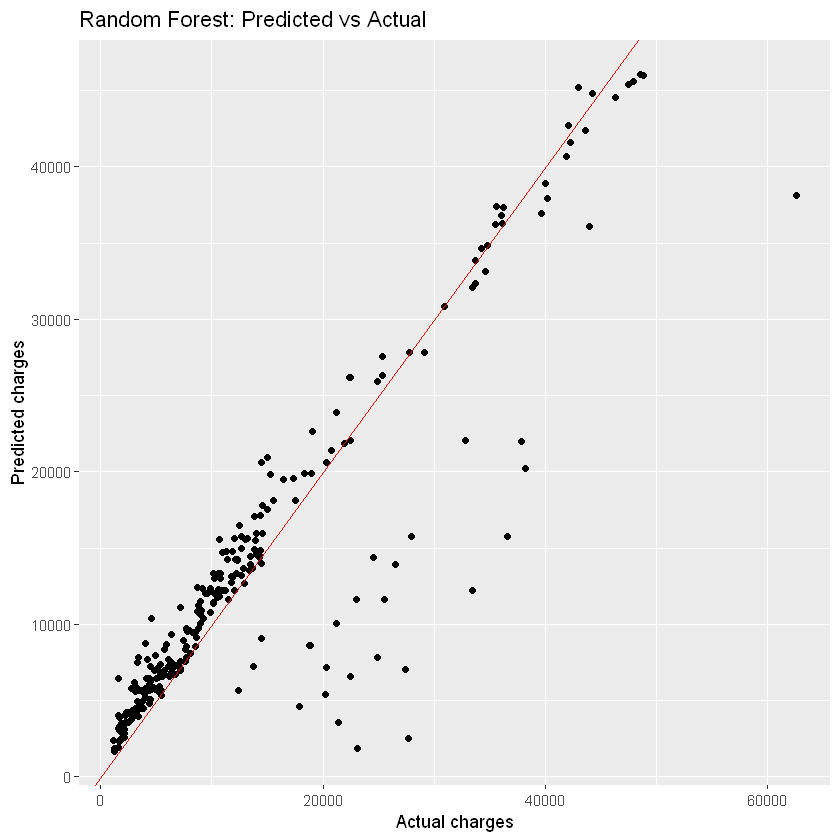

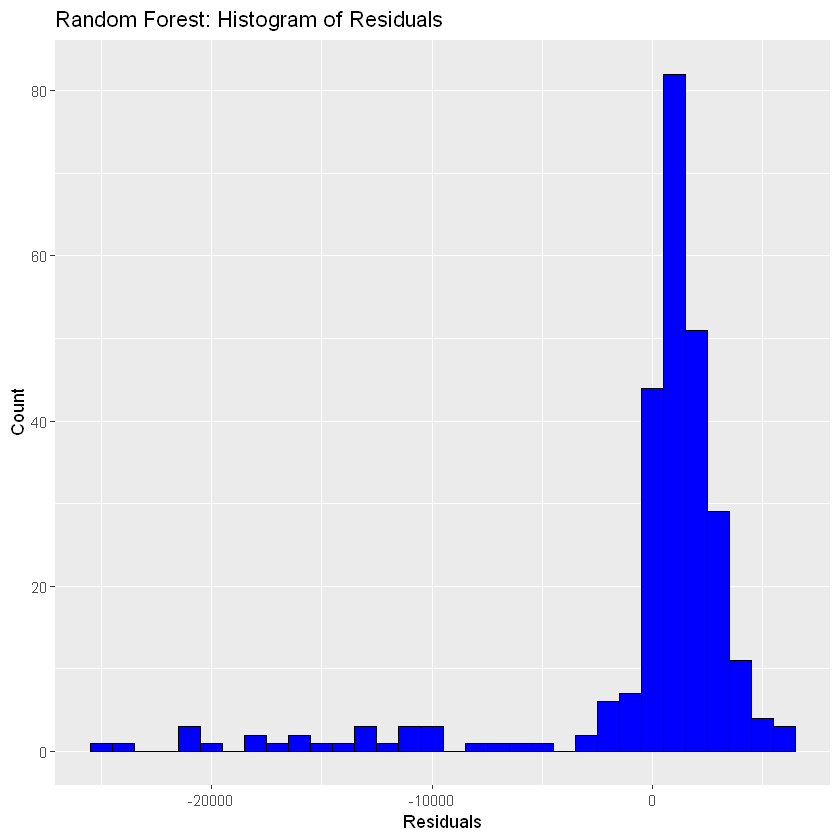

In [9]:
# RF model plots
df_rf <- data.frame(Actual = test_data$charges, Predicted = predictions_rf)
ggplot(df_rf, aes(x = Actual, y = Predicted)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  ggtitle("Random Forest: Predicted vs Actual") +
  xlab("Actual charges") + ylab("Predicted charges")

df_rf$residuals <- df_rf$Predicted - df_rf$Actual
ggplot(df_rf, aes(x = residuals)) +
  geom_histogram(binwidth = 1000, fill = 'blue', color = 'black') +
  ggtitle("Random Forest: Histogram of Residuals") +
  xlab("Residuals") + ylab("Count")

In [10]:
# XGBoost model

# Convert data to xgb.DMatrix format
train_data_mat <- xgb.DMatrix(data = as.matrix(train_data[,-which(names(train_data) == "charges")]), label = train_data$charges)
test_data_mat <- xgb.DMatrix(data = as.matrix(test_data[,-which(names(test_data) == "charges")]), label = test_data$charges)

params <- list(booster = "gbtree", objective = "reg:squarederror", eta = 0.05, max_depth = 3, subsample = 1, colsample_bytree = 1)

model_xgb <- xgb.train(params = params, data = train_data_mat, nrounds = 100)
predictions_xgb <- predict(model_xgb, newdata = test_data_mat)
RMSE(predictions_xgb, test_data$charges)
rmse_xgb <- RMSE(predictions_xgb, test_data$charges)

[1] 5164.75

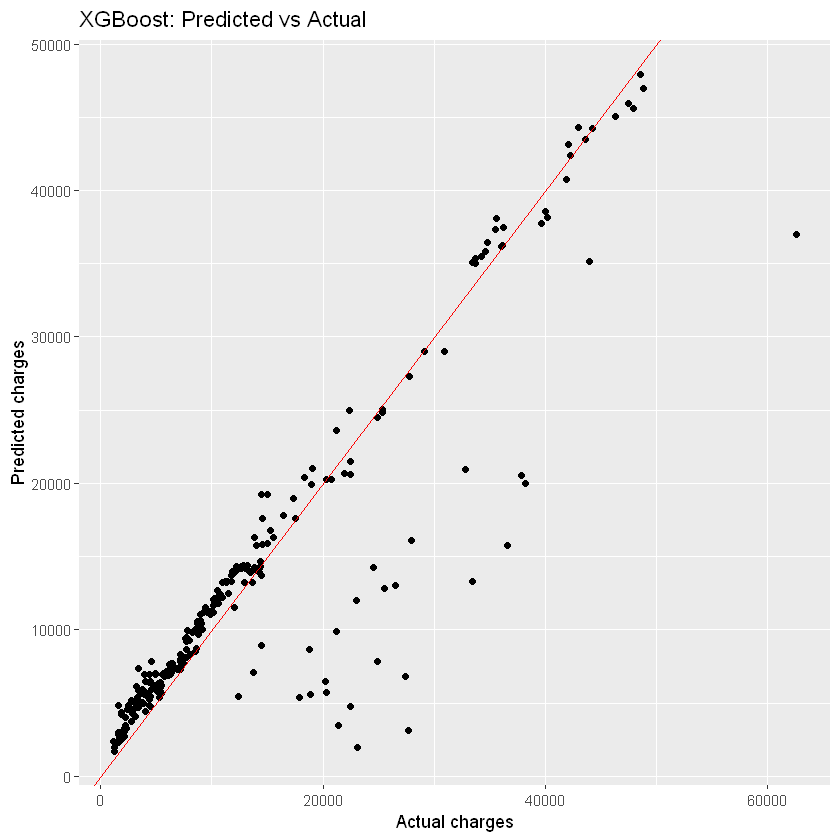

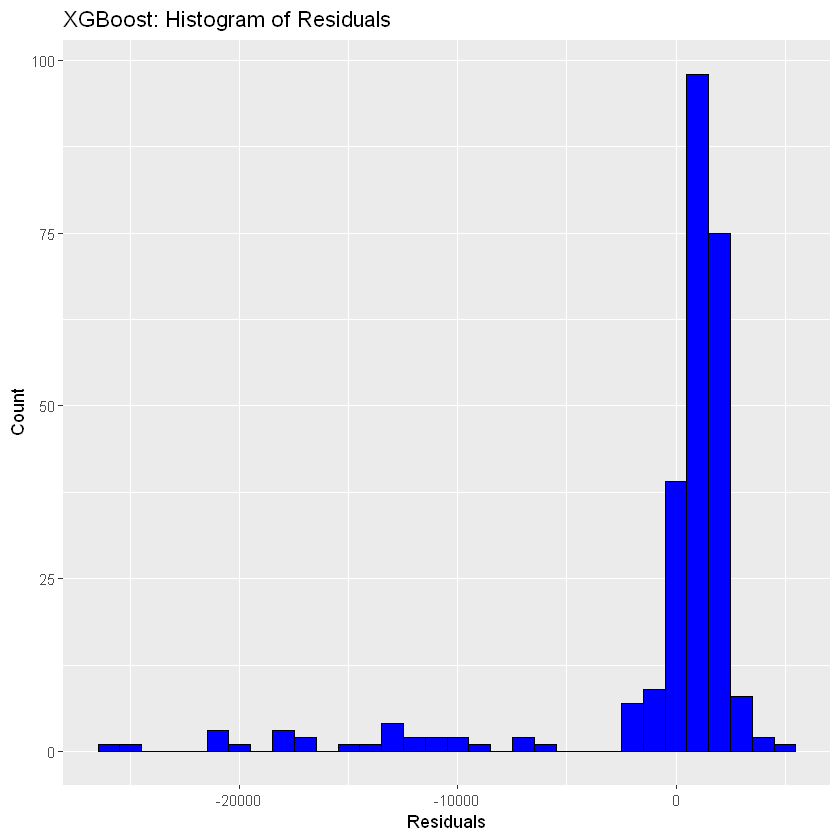

In [11]:
# XGBoost model plots
df_xgb <- data.frame(Actual = test_data$charges, Predicted = predictions_xgb)
ggplot(df_xgb, aes(x = Actual, y = Predicted)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  ggtitle("XGBoost: Predicted vs Actual") +
  xlab("Actual charges") + ylab("Predicted charges")

df_xgb$residuals <- df_xgb$Predicted - df_xgb$Actual
ggplot(df_xgb, aes(x = residuals)) +
  geom_histogram(binwidth = 1000, fill = 'blue', color = 'black') +
  ggtitle("XGBoost: Histogram of Residuals") +
  xlab("Residuals") + ylab("Count")

In [ ]:
optimize_lgb <- function(num_leaves, learning_rate) {
  params <- list(objective = "regression", 
                 metric = "rmse", 
                 num_leaves = as.integer(num_leaves), 
                 learning_rate = learning_rate, 
                 min_data = 1)
  
  cv_result <- lgb.cv(params, train_data_lgb, nrounds = 100, nfold = 5, early_stopping_rounds = 10)
  
  # Retrieve the final (minimum) RMSE
  min_rmse <- tail(cv_result$record_evals$valid$rmse$eval, n = 1)[[1]]
  
  # If RMSE is Inf, return a large value
  if (is.infinite(min_rmse)) {
    score <- 1e6
  } else {
    # Otherwise, use negated RMSE as the score to maximize
    score <- -min_rmse
  }

  return(list(Score = score))
}

# Define the search space
search_grid <- list(num_leaves = c(5, 100), learning_rate = c(0.003, 0.5))

# Run the optimization
bayes_opt_result <- BayesianOptimization(optimize_lgb, 
                                         bounds = search_grid, 
                                         init_points = 5, 
                                         n_iter = 40)

In [12]:
train_data_lgb <- lgb.Dataset(data.matrix(dplyr::select(train_data, -charges)), label = train_data$charges)
test_data_lgb <- lgb.Dataset(data.matrix(dplyr::select(test_data, -charges)), label = test_data$charges)

params <- list(objective = "regression", metric = "rmse", learning_rate = 0.2, num_leaves = 5)

model_lgb <- lgb.train(params, train_data_lgb, valids = list(test = test_data_lgb), nrounds = 300, early_stopping_rounds = 10)
predictions_lgb <- predict(model_lgb, data.matrix(dplyr::select(test_data, -charges)))
RMSE(predictions_lgb, test_data$charges)
rmse_lgb <- RMSE(predictions_lgb, test_data$charges)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 1072, number of used features: 9
[LightGBM] [Info] Start training from score 13253.012534
[1] "[1]:  test's rmse:10133.9"
[1] "[2]:  test's rmse:8725.64"
[1] "[3]:  test's rmse:7737.69"
[1] "[4]:  test's rmse:7011.8"
[1] "[5]:  test's rmse:6466.16"
[1] "[6]:  test's rmse:6133.89"
[1] "[7]:  test's rmse:5907.24"
[1] "[8]:  test's rmse:5754.35"
[1] "[9]:  test's rmse:5656.36"
[1] "[10]:  test's rmse:5585.95"
[1] "[11]:  test's rmse:5472.36"
[1] "[12]:  test's rmse:5419.95"
[1] "[13]:  test's rmse:5380.96"
[1] "[14]:  test's rmse:5350.88"
[1] "[15]:  test's rmse:5330.24"
[1] "[16]:  test's rmse:5314.38"
[1] "[17]:  test's rmse:5304"
[1] "[18]:  test's rmse:5285.38"
[1] "[19]

[1] 5220.932

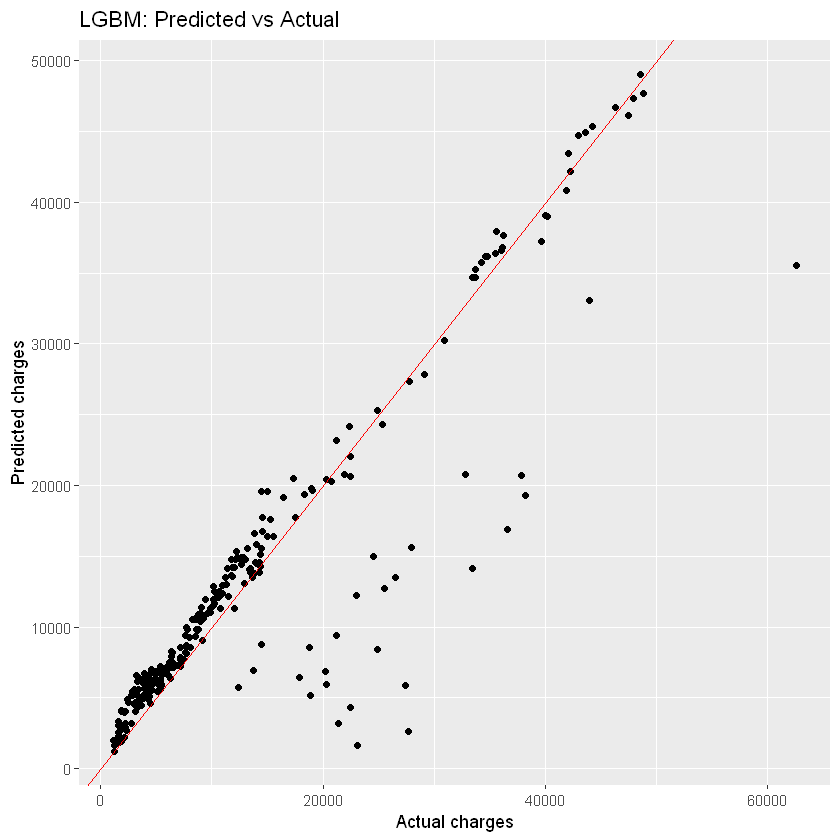

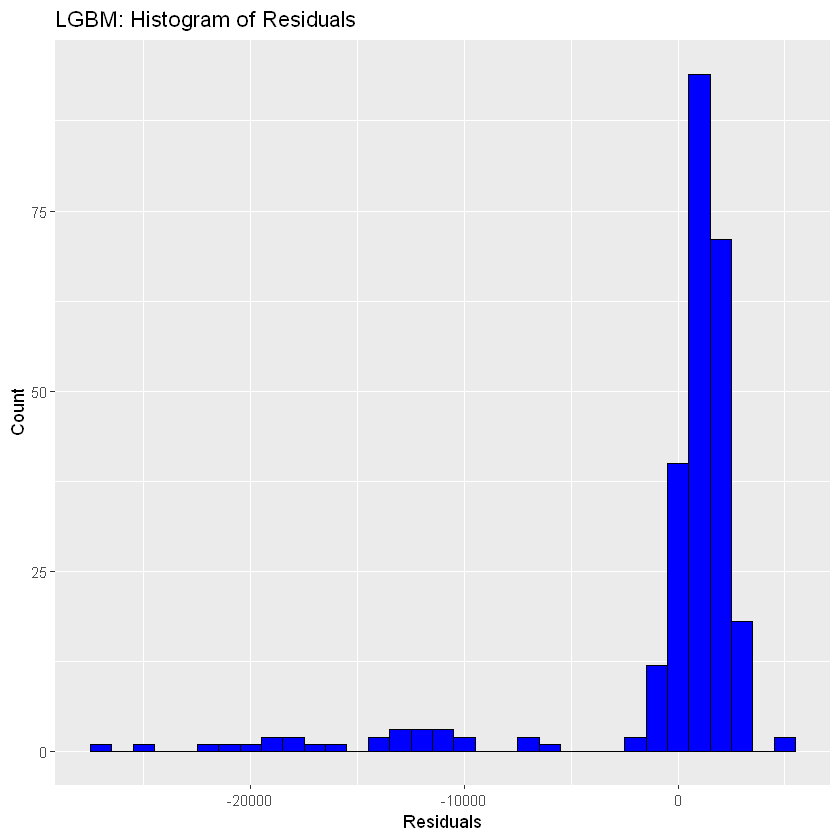

In [13]:
# LGBM model plots
df_lgb <- data.frame(Actual = test_data$charges, Predicted = predictions_lgb)
ggplot(df_lgb, aes(x = Actual, y = Predicted)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  ggtitle("LGBM: Predicted vs Actual") +
  xlab("Actual charges") + ylab("Predicted charges")

df_lgb$residuals <- df_lgb$Predicted - df_lgb$Actual
ggplot(df_lgb, aes(x = residuals)) +
  geom_histogram(binwidth = 1000, fill = 'blue', color = 'black') +
  ggtitle("LGBM: Histogram of Residuals") +
  xlab("Residuals") + ylab("Count")

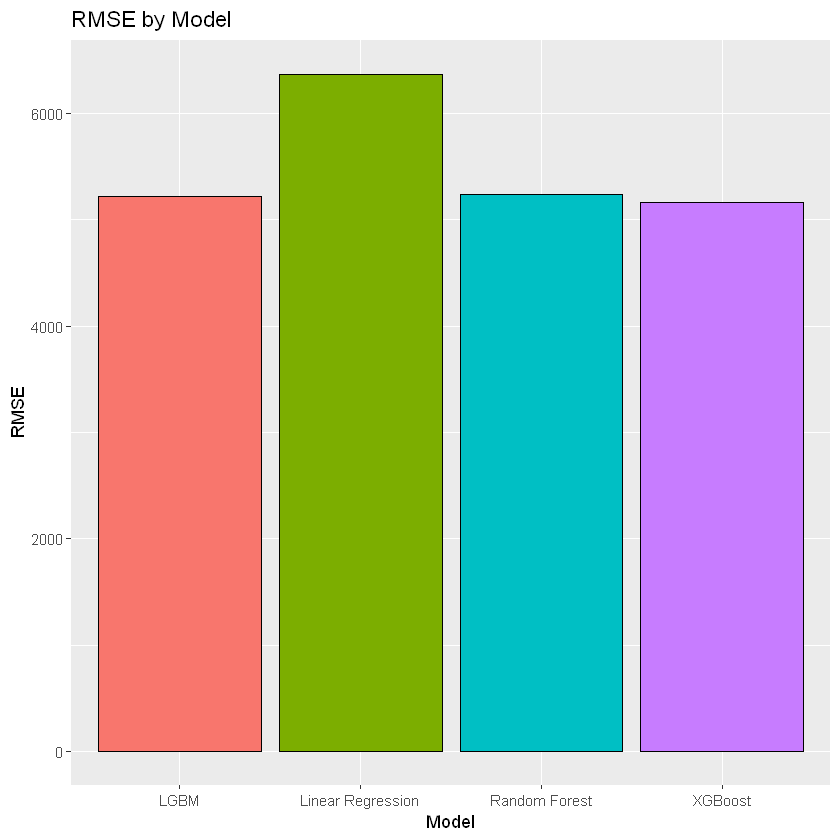

In [14]:
df_rmse <- data.frame(Model = c("Linear Regression", "Random Forest", "XGBoost", "LGBM"),
                      RMSE = c(rmse_lr, rmse_rf, rmse_xgb, rmse_lgb))

ggplot(df_rmse, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity", color = "black") +
  ggtitle("RMSE by Model") +
  xlab("Model") + ylab("RMSE") +
  theme(legend.position = "none")